## Import packages.

In [1]:
import sys

In [3]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as pl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.axes as ax
import pandas as pd
import pylab as plt
import numpy as np
import math
import nltk
import string
import spacy
nlp = spacy.load('en_core_web_sm')

import pickle as pickle
import gudhi as gd

from gudhi.representations import *
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.manifold import MDS

from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from itertools import count
from itertools import cycle
from pandas import DataFrame
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import LogFormatter
from matplotlib.font_manager import FontProperties
from matplotlib import ticker
from matplotlib import rc
from collections import defaultdict

# Directed graphs documentation: https://networkx.org/documentation/latest/_modules/networkx/classes/digraph.html

## Define *some* initial functions to be used.

### New colormap:

In [4]:
top = cm.get_cmap('summer', 256)
# bottom = cm.get_cmap('autumn_r', 256)
bottom = cm.get_cmap('spring_r', 256)

newcolors = np.vstack((top(np.linspace(0.25, 1, 64)),
                       bottom(np.linspace(0, 0.75, 192))))
newcmp = ListedColormap(newcolors, name='GreenRedish')

### Clean text:

#### *Note: uncomment the nouns row to build other kind of graph.*

In [5]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # tags the words
    text = nltk.pos_tag(text)
    # keeps only the nouns
    text = [word for word, pos in text if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    
    return(text)

### Build WordNet graph:

In [6]:
def wordnet_graph(words):    
    """
    Construct a graph where each word is a vertex.
    """   
    graph = nx.DiGraph()
    labels = {}
    seen = set()
    degrees = graph.degree() # nearest neighbour definitions of each word.
    definition_list = set() # collection of individual words used in the definition of other words.
    full_definition = set() # the complete definition of each word.
    
    def recurse(s):
        if not s in seen:
            # adds the word in synset form: "Synset('word.n.01')", to the seen() set.
            seen.add(s)
            # takes synset and transforms into 'word' format.
            sw = s.name().split(".")[0]
            # add a node in the form: 'word', to the graph.
            graph.add_node(sw)
            # returns definition of the synset i.e. using the Synset('word.n.01') format.
            definition = s.definition()
            # clean the text by removing 'stop' words and nouns.
            definition_split = clean_text(definition)
            # adds the full definition of the word to a set.
            full_definition.add(definition)
            
            for d in definition_split:
                # takes all words from the 'defined' list:
                graph.add_node(d)
                graph.add_edge(sw, d)
                definition_list.add(d)
                
                ds = wn.synsets(d)
                
                # Pass statement 
                if len(ds)>0:
                    for i in ds:
                        s2 = wn.synsets(d)[0]
                        recurse(s2)
                    pass
    
    for word in words:
        # takes all synonyms of the word:
        synsets = wn.synsets(word)
        
        for synset in synsets:
            s = wn.synsets(word)[0] ## what would happen if did not take the first one synset?
            recurse(s)
        
    return graph, seen, degrees, definition_list, full_definition

## 2) Take some document off of Brown Corpus:

#### *Text corpora location: http://icame.uib.no/brown/bcm.html#tc, Accessing text corpora: https://www.nltk.org/book/ch02.html.*

In [7]:
text_words = nltk.Text(nltk.corpus.brown.words(fileids=['ca40'])) # TIME magazine - January 13, 1961.

In [8]:
len(text_words)

2340

In [9]:
graph, seen, degrees, definition_list, full_definition = wordnet_graph(text_words)

In [10]:
len(graph)

5062

### Remove self-loops (where a word is used inside the defition of itself) as this can be considered to be redundant:

In [11]:
graph.remove_edges_from(nx.selfloop_edges(graph))

In [12]:
len(graph)

5062

## 3) Find the strongly connected components inside a graph.

### Find SCC's:

In [13]:
nx.number_strongly_connected_components(graph)

4300

In [14]:
S = [graph.subgraph(c).copy() for c in nx.strongly_connected_components(graph)]

In [15]:
GS = []

for ss in range(len(S)):
    if len(S[ss].nodes)>2:
        GS.append(S[ss])

In [16]:
len(GS)

17

In [17]:
GS[0].edges

OutEdgeView([('information', 'message'), ('message', 'communication'), ('communication', 'information')])

In [18]:
def biggest_connected_subgraph(G):
    if G.is_directed():
        components = nx.strongly_connected_components(G)
    biggest = max(components, key=len)
    
    return G.subgraph(biggest)

In [19]:
len(biggest_connected_subgraph(graph))

668

In [20]:
print("Length of text document: ", len(text_words))
print("Number of nodes inside graph: ", len(graph.nodes()))
print("Number of edges inside graph: ", len(graph.edges()))
print("Number of nodes inside SCC: ", len(biggest_connected_subgraph(graph).nodes()))
print("Number of edges inside SCC: ", len(biggest_connected_subgraph(graph).edges()))

Length of text document:  2340
Number of nodes inside graph:  5062
Number of edges inside graph:  11579
Number of nodes inside SCC:  668
Number of edges inside SCC:  1502


### Now select only the largest SCC:

In [21]:
def strongly_connected_component_subgraphs(G, copy=True):
    
    for comp in strongly_connected_components(G):
        if copy:
            yield G.subgraph(comp).copy()
            
        else:
            yield G.subgraph(comp) 

In [22]:
max_Gc = max(nx.strongly_connected_component_subgraphs(graph), key=len)

In [23]:
len(list(max_Gc))

668

### Draw graph:

In [24]:
from matplotlib.ticker import LogLocator

In [25]:
def plot_sub_graph(G):
    fig = plt.figure(figsize=(16, 16))
    fig.set_facecolor("#00000F")
    
    degree_values = [v for k, v in G.degree()]
    nodes = degree_values
    colors = [degree_values[i] for i in range(len(G.nodes))]
    
    pos=nx.kamada_kawai_layout(G)
#     pos=nx.spring_layout(G,
#                          iterations=2000) # reduce iterations if need to speed up computation
    nc = nx.draw_networkx_nodes(G, 
                                pos, 
                                alpha=0.9,
                                cmap=newcmp,
                                node_color=colors, 
                                node_size=16
                               )
    
    nc.set_norm(mcolors.LogNorm()) # set to logarithm scale for easier plotting.
    
    ec = nx.draw_networkx_edges(G, 
                                pos, 
                                alpha=0.15,
                                edge_color="mintcream",
                                arrows=False
                               )
#     nx.draw_networkx_labels(G, pos, font_color="mintcream")
    
    # more formatting options.
    formatter = LogFormatter(10, labelOnlyBase=False)
    cb = plt.colorbar(nc, format=formatter, orientation='horizontal', extend='max', aspect=50, pad=0.05)
    cb.set_label('Degree of word', color="mintcream", size=16)
    cb.ax.xaxis.set_major_locator(LogLocator(10.0, numticks=4))
    cb.ax.set_xticklabels(['','1','10','100','1000'])
#     cb.ax.xaxis.set_major_locator(ticker.LogLocator(10))
    cb.ax.tick_params(colors="mintcream", labelsize=12)
    cb.outline.set_edgecolor("mintcream")
#     plt.rcParams["text.color"]="mintcream"
#     plt.rcParams["axes.labelcolor"]="mintcream"
    plt.axis('off')
    plt.show()
    fig.savefig('dictionary-graph.png', bbox_inches="tight", facecolor="#00000F")

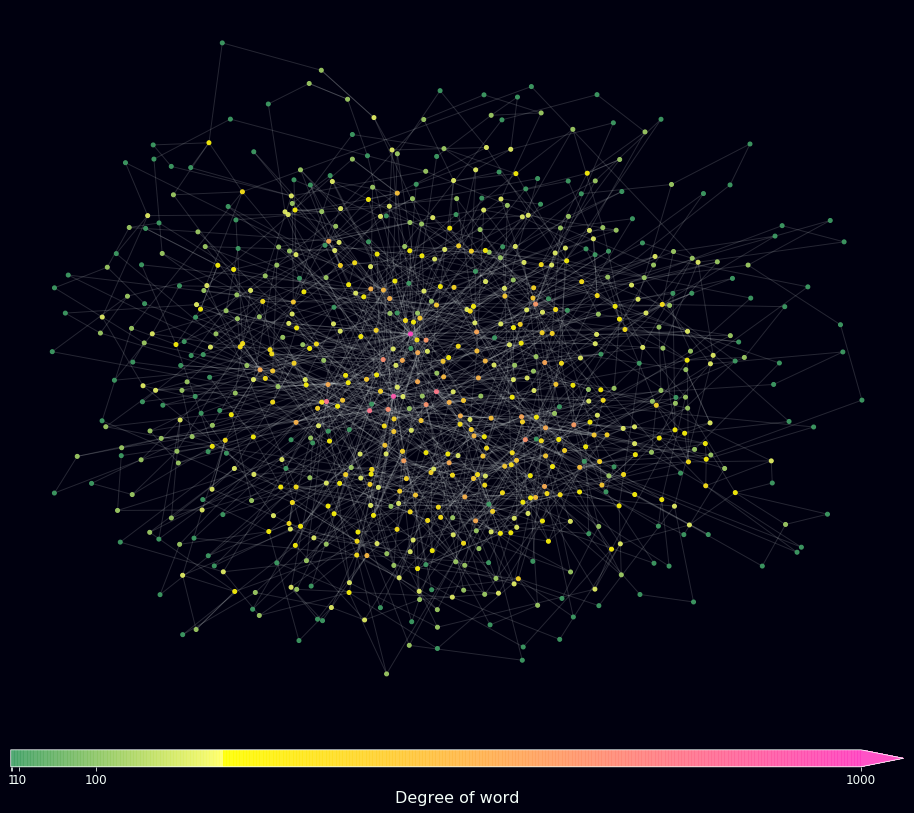

In [26]:
plot_sub_graph(biggest_connected_subgraph(graph))